## 生成数据

In [8]:
from captcha.image import ImageCaptcha
from scipy.misc import imread, imresize
from random import Random
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [9]:
chars = 'AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz0123456789'
def random_str(randomlength=8):
    str = ''
    chars = 'AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz0123456789'
    length = len(chars) - 1
    random = Random()
    for i in range(randomlength):
        str+=chars[random.randint(0, length)]
    return str

def random_img(string):
    image = ImageCaptcha()
    data = np.array(image.generate_image(string))
    return data

def generate_dataset(numbers):
    dataset = np.zeros([numbers, 60, 160, 3], dtype= np.uint8)
    labels = []
    onehot_labels= np.zeros([numbers, 4, 62], dtype= np.uint8)
     
    for i in range(numbers):
        label = random_str(4)
        img = random_img(label)
        onehot_label = np.zeros([len(label),len(chars)])
        for j in range(len(label)):
            for k in range(len(chars)):
                if label[j] == chars[k]:
                    onehot_label[j,k] = 1.
        resize_img = imresize(img, size=(60,160))
        dataset[i] = resize_img
        labels.append(label)
        onehot_labels[i] = onehot_label
    return dataset, labels, onehot_labels

def loadPickle(file):
    try:
        with open(file, 'rb') as pickle_file:
            return pickle.load(pickle_file)
            print(file,'peckled!')
    except Exception as e:
        print('Unable to load', file, ':' , e)
        
def saveAsPickle(data,filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
            print (filename + " pickled!")
    except Exception as e:
        print('Unable to save data to', filename, ':', e)
        
def load_or_generate_dataset(numbers, datapath, labelspath, onehot_labels_path):
    if os.path.exists(datapath) & os.path.exists(labelspath) & os.path.exists(onehot_labels_path):
        data = loadPickle(datapath)
        labels = loadPickle(labelspath)
        onehot_labels = loadPickle(onehot_labels_path)
    else :
        print('File not exist, will generate data soon...')
        data, labels, onehot_labels = generate_dataset(numbers)
        saveAsPickle(data, datapath)
        saveAsPickle(labels,labelspath)
        saveAsPickle(onehot_labels,onehot_labels_path)
    return data, labels, onehot_labels

def decode(labels):
    str = []
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i,j] == 1:
                str.append(chars[j])
    return str

def check_data(img, labels, prediction = None, number = 0):
    str = decode(labels[number])
    if prediction !=  None:
        predict_labels = []
        for i in prediction[number]:
            predict_labels.append(chars[np.argmax(i)])
        print('The img predict is ', predict_labels)
    print('The img lables is ',str)
    plt.imshow(img[number])
    

In [10]:
dataset , labels, onehot_labels = load_or_generate_dataset(60000, 'dataset.pickle', 'labels.pickle', 'onehot_labels.pickle')

File not exist, will generate data soon...
dataset.pickle pickled!
labels.pickle pickled!
onehot_labels.pickle pickled!


('The img lables is ', ['3', 'M', 'R', 'B'])


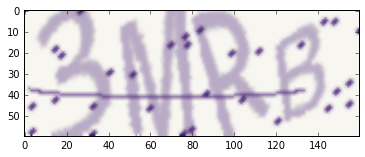

In [11]:
check_data(dataset, onehot_labels, number=2)

In [12]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset, train_labels, test_labels = train_test_split(
    dataset, onehot_labels, test_size = 10000)

In [13]:
train_labels = [train_labels[:,0,:],train_labels[:,1,:],train_labels[:,2,:],train_labels[:,3,:]]
test_labels = [test_labels[:,0,:],test_labels[:,1,:],test_labels[:,2,:],test_labels[:,3,:]]

In [14]:
from keras.layers import merge, Convolution2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from keras.regularizers import l2, activity_l2
from keras.models import Model

Using TensorFlow backend.


In [55]:
digit_input = Input(shape = (60 ,160, 3))

# Block 1
x = Convolution2D(8, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block1_conv1')(digit_input)
x = Convolution2D(8, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Convolution2D(16, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block2_conv1')(x)
x = Convolution2D(16, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Convolution2D(32, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block3_conv1')(x)
x = Convolution2D(32, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block3_conv2')(x)
x = Convolution2D(32, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

'''
# Block 4
x = Convolution2D(64, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block4_conv1')(x)
x = Convolution2D(64, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block4_conv2')(x)
x = Convolution2D(64, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


# Block 5
x = Convolution2D(64, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block5_conv1')(x)
x = Convolution2D(64, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block5_conv2')(x)
x = Convolution2D(64, 3, 3, init='he_uniform', activation='relu', border_mode='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
'''

x = Flatten(name='flatten')(x)
x = Dropout(0.5, name = 'drop1')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dropout(0.5, name = 'drop2')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dropout(0.5, name = 'drop3')(x)

outputs = []

for i in range(4):
    output = Dense(62,activation = 'softmax', W_regularizer=l2(0.01), name = 'output'+ str(i))(x)
    outputs.append(output)

model = Model(input = digit_input, output = outputs)

model.compile(optimizer = 'adadelta', loss = 'categorical_crossentropy', metrics={'output0':'accuracy','output1':'accuracy','output2':'accuracy','output3':'accuracy'})
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_14 (InputLayer)            (None, 60, 160, 3)    0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 60, 160, 8)    224         input_14[0][0]                   
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 60, 160, 8)    584         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 30, 80, 8)     0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [57]:
model.fit(train_dataset, train_labels, batch_size = 128, nb_epoch = 40, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/40
61s - loss: 5.9170 - output0_loss: 0.6808 - output1_loss: 1.1388 - output2_loss: 1.3799 - output3_loss: 1.0975 - output0_acc: 0.7491 - output1_acc: 0.6109 - output2_acc: 0.5521 - output3_acc: 0.6249 - val_loss: 2.6949 - val_output0_loss: 0.3689 - val_output1_loss: 0.7121 - val_output2_loss: 0.9186 - val_output3_loss: 0.6953 - val_output0_acc: 0.8506 - val_output1_acc: 0.7456 - val_output2_acc: 0.6810 - val_output3_acc: 0.7526
Epoch 2/40
61s - loss: 5.1624 - output0_loss: 0.5652 - output1_loss: 0.9148 - output2_loss: 1.0967 - output3_loss: 0.8707 - output0_acc: 0.7924 - output1_acc: 0.6833 - output2_acc: 0.6326 - output3_acc: 0.6985 - val_loss: 2.2885 - val_output0_loss: 0.3460 - val_output1_loss: 0.5927 - val_output2_loss: 0.7634 - val_output3_loss: 0.5864 - val_output0_acc: 0.8636 - val_output1_acc: 0.8008 - val_output2_acc: 0.7436 - val_output3_acc: 0.7916
Epoch 3/40
61s - loss: 4.6529 - output0_loss: 0.4875 - output1_loss: 

In [ ]:
model.evaluate(test_dataset, test_labels, batch_size=1000, verbose=1)

In [41]:
predict_labels = model.predict(test_dataset)

In [42]:
prediction = np.zeros([10000, 4, 62])
for i in range(4):
    prediction[:,i,:] = predict_labels[i]

In [43]:
def accuracy(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    right = 0.
    for i in range(y_pred.shape[1]):
        final_predict = []
        true_labels = []
        for j in range(y_pred.shape[0]):
            final_predict.append(np.argmax(y_pred[j,i,:]))
            true_labels.append(np.argmax(y_true[j,i,:]))
        if final_predict == true_labels:
            right += 1.
    acc = right / y_true.shape[1]
    print('Model accuracy is ' + str(acc) )

In [44]:
accuracy(test_labels,predict_labels)

Model accuracy is 0.6528


('The img predict is ', ['e', '2', 'e', 'S'])
('The img lables is ', ['O', 'O', 'M', 'A'])


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


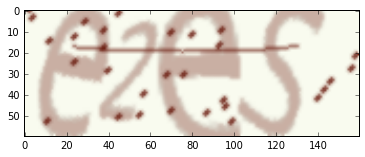

In [31]:
check_data(test_dataset, np.array(test_labels).reshape([10000, 4, 62]), prediction, number=2)

In [30]:
np.array(test_labels).reshape([10000, 4, 62])

(4, 10000, 62)